In [1]:
import numpy as np
import torch
from data import ceasar_shift, convert_data
from torch import nn
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from model import Generator, Discriminator, GeneratorV2, DiscriminatorV2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

## Init parameters

In [2]:
# init parameters
torch.manual_seed(1)
np.random.seed(1)
batch_size = 1024
num_epochs = 20
lr_gen = 0.0002
lr_discr = 0.0001
beta1 = 0
beta2 = 0.9
device = "cuda" if torch.cuda.is_available() else "cpu"
shift = 10
reg = 1000
instance_size = 100
dictionary_size = 27

## Load data


In [3]:
## Create data
np_data = convert_data(fixed_len=instance_size)
np_crypted_data = ceasar_shift(np_data, shift)

tensor_clear_text = torch.from_numpy(np_data)
tensor_crypted_data = torch.from_numpy(np_crypted_data)

tensor_clear_text = tensor_clear_text.float().view(-1, 1, instance_size, dictionary_size)
tensor_crypted_data = tensor_crypted_data.float().view(-1, 1, instance_size, dictionary_size)

num_train = len(tensor_clear_text)
indices_clear = list(range(num_train))
np.random.shuffle(indices_clear)
train_split_clear = int(np.floor(0.6 * num_train))
test_split_clear = int(np.floor(0.8 * num_train))


num_train = len(tensor_clear_text)
indices_crypted = list(range(num_train))
np.random.shuffle(indices_crypted)
train_split_crypted = int(np.floor(0.6 * num_train))
test_split_crypted = int(np.floor(0.8 * num_train))

clear_txt_train = tensor_clear_text[:train_split_clear]
clear_txt_test = tensor_clear_text[train_split_clear:test_split_clear]
clear_txt_valid = tensor_clear_text[test_split_clear:]

crypted_txt_train = tensor_crypted_data[:train_split_crypted]
crypted_txt_test = tensor_crypted_data[train_split_crypted:test_split_crypted]
crypted_txt_valid = tensor_crypted_data[test_split_crypted:]

(24206, 100, 27) int32
(24206, 100, 27) int32


## Create data loaders

In [4]:
train_clear_loader = DataLoader(clear_txt_train, batch_size=batch_size)
train_crypted_loader = DataLoader(crypted_txt_train, batch_size=batch_size)

## Init models

In [5]:
crypted_gen = GeneratorV2(instance_size, dictionary_size).to(device) # converts clear to crypted
clear_gen = GeneratorV2(instance_size, dictionary_size).to(device) # converts crypted to clear
crypted_discr = DiscriminatorV2(instance_size, dictionary_size).to(device)
clear_discr = DiscriminatorV2(instance_size, dictionary_size).to(device)

# Setup Adam optimizers for both generators
optimizer_crypted_gen = optim.Adam(crypted_gen.parameters(), lr=lr_gen, betas=(beta1, beta2))
optimizer_clear_gen = optim.Adam(clear_gen.parameters(), lr=lr_gen, betas=(beta1, beta2))

# Setup Adam optimizers for both discriminators
optimizer_crypted_discr= optim.Adam(crypted_discr.parameters(), lr=lr_discr)
optimizer_clear_discr = optim.Adam(clear_discr.parameters(), lr=lr_discr)

# Create Losses
BCE = nn.BCELoss()
cross_entropy = nn.CrossEntropyLoss()

## init loop variables

In [6]:
plots = {
"crypted_gen_loss_hist" : [],
"clear_gen_loss_hist" : [],
"crypted_discr_loss_hist" : [],
"clear_discr_loss_hist" : [],
"crypted_gen_acc_hist" : [],
"clear_gen_acc_hist" : [],
"crypted_discr_acc_hist" : [],
"crypted_discr_acc_hist_fake" : [],
"clear_discr_acc_hist" : [],
"clear_discr_acc_hist_fake" : [],
"test_decrypted_accuracy_hist" : [],
"test_encrypted_accuracy_hist" : []
}

In [7]:
with torch.no_grad():
    # Create the True encryption of each test instance
    test_crypt_np = crypted_txt_test.view(-1,instance_size,dictionary_size).detach().numpy()
    test_decrypted_np = ceasar_shift(test_crypt_np, -shift)
    test_decrypted_np_char = np.argmax(test_decrypted_np, axis=2).reshape(-1)
    test_decrypted = torch.from_numpy(test_decrypted_np_char).to(device)
    crypted_txt_test = crypted_txt_test.float().to(device)

    # Create the True decryption of each test instance
    test_clear_np = clear_txt_test.view(-1,instance_size,dictionary_size).detach().numpy()
    test_encrypted_np = ceasar_shift(test_clear_np, shift)
    test_encrypted_np_char = np.argmax(test_encrypted_np, axis=2).reshape(-1)
    test_encrypted = torch.from_numpy(test_encrypted_np_char).to(device)
    clear_txt_test = clear_txt_test.float().to(device)

(4841, 100, 27) int32
(4841, 100, 27) int32


# train loop

In [8]:
torch.autograd.set_detect_anomaly(True)
for epoch in range(num_epochs):

    dataloader_iterator = iter(train_crypted_loader)

    for i, clear in enumerate(train_clear_loader):
        crypted_gen.train()
        clear_gen.train()
        crypted_discr.train()
        clear_discr.train()
        try:
            crypted = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(train_clear_loader)
            crypted = next(dataloader_iterator)

        real_clear_text = clear.to(device)
        real_crypted_text = crypted.to(device)
        fake_clear_text = clear_gen(real_crypted_text)
        fake_crypted_text = crypted_gen(real_clear_text)

        ## train clear discr on true data
        clear_discr.zero_grad()
        pred_real_clear = clear_discr(real_clear_text)
        true_labels = torch.full((len(real_clear_text),1), 1, dtype=torch.float, device=device)
        batch_clear_d_true_loss = BCE(pred_real_clear, true_labels)
        batch_clear_d_true_loss.backward()

        ## train clear Discr on fake data.py
        pred_fake_clear  = clear_discr(fake_clear_text.detach())
        fake_labels = torch.full((len(real_clear_text),1), 0, dtype=torch.float, device=device)
        batch_clear_d_fake_loss = BCE(pred_fake_clear, fake_labels)
        batch_clear_d_fake_loss.backward()
        error_d_clear = batch_clear_d_fake_loss + batch_clear_d_true_loss
        plots["clear_discr_loss_hist"].append(error_d_clear.item())
        optimizer_clear_discr.step()

        ## train crypted discr on true data
        crypted_discr.zero_grad()
        pred_real_crypted = crypted_discr(real_crypted_text)
        true_labels = torch.full((len(real_crypted_text),1), 1, dtype=torch.float, device=device)
        batch_crypted_d_true_loss = BCE(pred_real_crypted, true_labels)
        batch_crypted_d_true_loss.backward()

        ## train crypted Discr on fake data
        pred_fake_crypted  = crypted_discr(fake_crypted_text.detach())
        fake_labels = torch.full((len(fake_crypted_text),1), 0, dtype=torch.float, device=device)
        batch_crypted_d_fake_loss = BCE(pred_fake_crypted, fake_labels)
        batch_crypted_d_fake_loss.backward()
        error_d_crypted = batch_crypted_d_fake_loss + batch_crypted_d_true_loss
        plots["crypted_discr_loss_hist"].append(error_d_crypted.item())
        optimizer_crypted_discr.step()

        ## train clear gen
        clear_gen.zero_grad()
        crypted_gen.zero_grad()
        gen_fake_clear = clear_discr(fake_clear_text)
        gen_labels = torch.full((len(fake_clear_text),1), 1, dtype=torch.float, device=device)
        fake_gen_clear_loss = BCE(gen_fake_clear, gen_labels)
        fake_gen_clear_loss.backward()

        fake_crypted_reconstruct = crypted_gen(clear_gen(real_crypted_text))
        fake_crypted_reconstruct_loss = torch.linalg.norm((fake_crypted_reconstruct - real_crypted_text)**2, dim=(2,3)).mean() * reg
        # fake_crypted_reconstruct_loss = cross_entropy(fake_crypted_reconstruct.view(-1, instance_size, dictionary_size).transpose(1,2), torch.argmax(real_crypted_text, 3).view(-1,instance_size))
        fake_crypted_reconstruct_loss.backward()

        fake_clear_reconstruct =  clear_gen(crypted_gen(real_clear_text))
        fake_clear_reconstruct_loss = torch.linalg.norm((fake_clear_reconstruct - real_clear_text)**2, dim=(2,3)).mean() * reg
        # fake_clear_reconstruct_loss = cross_entropy(fake_clear_reconstruct.view(-1, instance_size, dictionary_size).transpose(1,2), torch.argmax(real_clear_text, 3).view(-1,instance_size))
        fake_clear_reconstruct_loss.backward()

        batch_clear_gen_loss = fake_gen_clear_loss + fake_crypted_reconstruct_loss + fake_clear_reconstruct_loss
        # batch_clear_gen_loss.backward()
        optimizer_clear_gen.step()
        plots["clear_gen_loss_hist"].append(batch_clear_gen_loss.item())

        ## train crypted gen
        crypted_gen.zero_grad()
        clear_gen.zero_grad()
        gen_fake_crypted = crypted_discr(fake_crypted_text)
        gen_labels = torch.full((len(fake_crypted_text),1), 1, dtype=torch.float, device=device)
        fake_gen_crypted_loss = BCE(gen_fake_crypted, gen_labels)
        fake_gen_crypted_loss.backward()

        fake_crypted_reconstruct = crypted_gen(clear_gen(real_crypted_text))
        fake_crypted_reconstruct_loss = torch.linalg.norm((fake_crypted_reconstruct - real_crypted_text)**2, dim=(2,3)).mean() * reg
        # fake_crypted_reconstruct_loss = cross_entropy(fake_crypted_reconstruct.view(-1, instance_size, dictionary_size).transpose(1,2), torch.argmax(real_crypted_text, 3).view(-1,instance_size))
        fake_crypted_reconstruct_loss.backward()

        fake_clear_reconstruct =  clear_gen(crypted_gen(real_clear_text))
        fake_clear_reconstruct_loss = torch.linalg.norm((fake_clear_reconstruct - real_clear_text)**2, dim=(2,3)).mean() * reg
        # fake_clear_reconstruct_loss = cross_entropy(fake_clear_reconstruct.view(-1, instance_size, dictionary_size).transpose(1,2), torch.argmax(real_clear_text, 3).view(-1,instance_size))
        fake_clear_reconstruct_loss.backward()

        batch_crypted_gen_loss = fake_gen_crypted_loss + fake_crypted_reconstruct_loss + fake_clear_reconstruct_loss
        # batch_crypted_gen_loss.backward()
        optimizer_crypted_gen.step()
        plots["crypted_gen_loss_hist"].append(batch_crypted_gen_loss.item())
        # print(epoch, i,crypted_gen_loss_hist[-1],clear_gen_loss_hist[-1],crypted_discr_loss_hist[-1],clear_discr_loss_hist[-1])
        crypted_gen.eval()
        clear_gen.eval()
        crypted_discr.eval()
        clear_discr.eval()
        with torch.no_grad():
            test_decrypted_gen = clear_gen(crypted_txt_test).view(-1,instance_size,dictionary_size).detach()
            test_decrypted_gen_char = torch.argmax(test_decrypted_gen, 2).view(-1)
            test_decrypted_accuracy = (test_decrypted==test_decrypted_gen_char).sum()/len(test_decrypted_gen_char)
            plots["test_decrypted_accuracy_hist"].append(test_decrypted_accuracy.to("cpu").item())

            test_encrypted_gen = crypted_gen(clear_txt_test).view(-1,instance_size,dictionary_size).detach()
            test_encrypted_gen_char = torch.argmax(test_encrypted_gen, 2).view(-1)
            test_encrypted_accuracy = (test_encrypted==test_encrypted_gen_char).sum()/len(test_encrypted_gen_char)
            plots["test_encrypted_accuracy_hist"].append(test_encrypted_accuracy.to("cpu").item())

            clear_discr_accuracy = torch.where(pred_real_clear >= 0.5, 1.0, 0.0).mean()
            clear_discr_accuracy_fake = torch.where((1-pred_fake_clear) >= 0.5, 1.0, 0.0).mean()
            plots["clear_discr_acc_hist"].append(clear_discr_accuracy.to("cpu").item())
            plots["clear_discr_acc_hist_fake"].append(clear_discr_accuracy_fake.to("cpu").item())
            crypted_discr_accuracy = torch.where(pred_real_crypted >= 0.5, 1.0, 0.0).mean()
            crypted_discr_accuracy_fake = torch.where((1-pred_fake_crypted) >= 0.5, 1.0, 0.0).mean()
            plots["crypted_discr_acc_hist"].append(crypted_discr_accuracy.to("cpu").item())
            plots["crypted_discr_acc_hist_fake"].append(crypted_discr_accuracy_fake.to("cpu").item())
            clear_gen_accuracy = torch.where(gen_fake_clear >= 0.5, 1.0, 0.0).mean()
            plots["clear_gen_acc_hist"].append(clear_gen_accuracy.to("cpu").item())
            crypted_gen_accuracy = torch.where(gen_fake_crypted >= 0.5, 1.0, 0.0).mean()
            plots["crypted_gen_acc_hist"].append(clear_gen_accuracy.to("cpu").item())
        clear_output()
        display("epoch : " + str(epoch))
        display("iteration : " + str(i))
        display("train loss crypt gen : " + str(plots["crypted_gen_loss_hist"][-1]))
        display("train loss clear gen : " + str(plots["clear_gen_loss_hist"][-1]))
        display("train loss crypt disc : " + str(plots["crypted_discr_loss_hist"][-1]))
        display("train loss clear disc : " + str(plots["clear_discr_loss_hist"][-1]))
        display("clear discr accuracy : " + str(plots["clear_discr_acc_hist"][-1]))
        display("clear discr fake accuracy : " + str(plots["clear_discr_acc_hist_fake"][-1]))
        display("crypted discr accuracy : " + str(plots["crypted_discr_acc_hist"][-1]))
        display("crypted discr fake accuracy : " + str(plots["crypted_discr_acc_hist_fake"][-1]))
        display("clear gen accuracy : " + str(plots["clear_gen_acc_hist"][-1]))
        display("crypted gen accuracy : " + str(plots["crypted_gen_acc_hist"][-1]))
        display("encrypting test accuracy : " +str(plots["test_encrypted_accuracy_hist"][-1]))
        display("decrypting test accuracy : " +str(plots["test_decrypted_accuracy_hist"][-1]))



'epoch : 9'

'iteration : 1'

'train loss crypt gen : 16655.03515625'

'train loss clear gen : 16670.2890625'

'train loss crypt disc : 0.003399168374016881'

'train loss clear disc : 0.5748794674873352'

'clear discr accuracy : 0.900390625'

'clear discr fake accuracy : 1.0'

'crypted discr accuracy : 1.0'

'crypted discr fake accuracy : 1.0'

'clear gen accuracy : 0.0'

'crypted gen accuracy : 0.0'

'encrypting test accuracy : 0.13392274081707'

'decrypting test accuracy : 0.11368312686681747'

KeyboardInterrupt: 

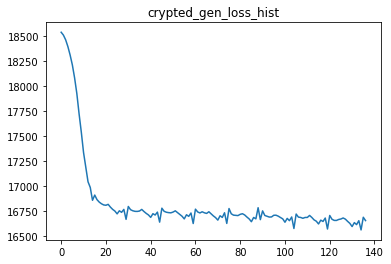

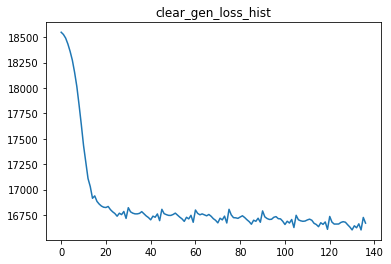

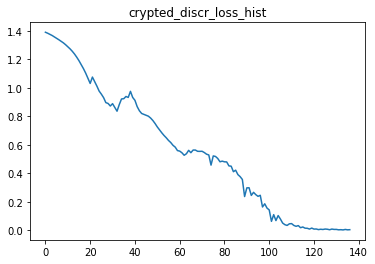

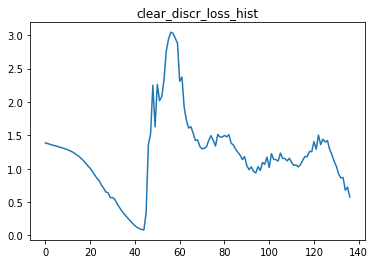

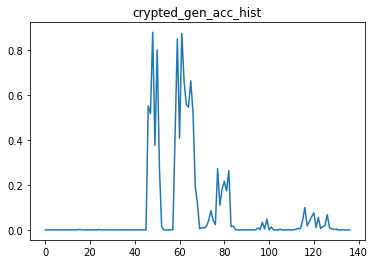

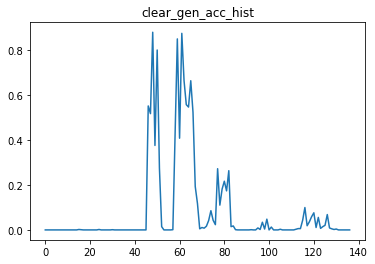

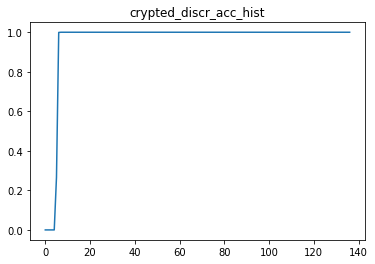

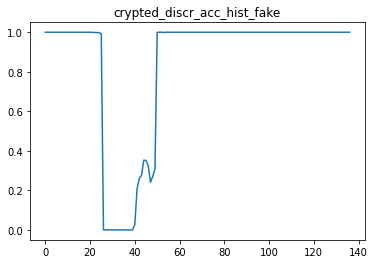

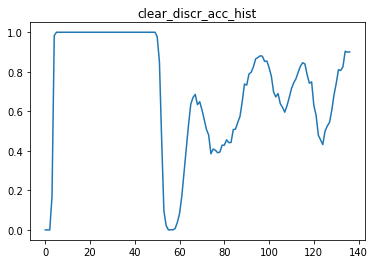

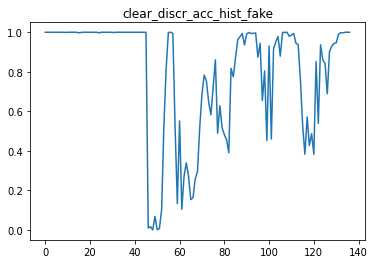

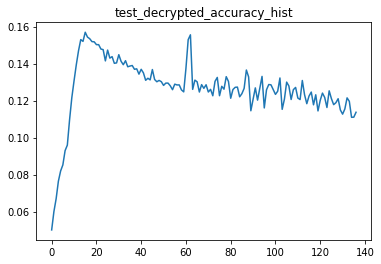

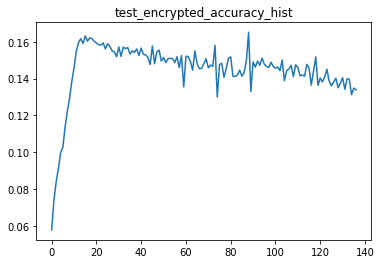

In [9]:

for key in plots:
    plt.figure()
    plt.title(str(key))
    plt.plot(plots[key])
    plt.show()
    plt.close()

In [10]:
crypted_gen.eval()
clear_gen.eval()
crypted_discr.eval()
clear_discr.eval()

with torch.no_grad():
    clear_gen = clear_gen.to("cpu")
    val_crypt_np = crypted_txt_valid.view(-1,instance_size,dictionary_size).detach().numpy()
    decrypted_np = ceasar_shift(val_crypt_np, -shift)
    decrypted_gen = clear_gen(crypted_txt_valid).view(-1,instance_size,dictionary_size).detach().numpy()
    decrypted_np_char = np.argmax(decrypted_np, axis=2).reshape(-1)
    decrypted_gen_char = np.argmax(decrypted_gen, axis=2).reshape(-1)
    print((decrypted_np_char == decrypted_gen_char).mean())

(4842, 100, 27) int32
0.11772201569599339


In [11]:
with torch.no_grad():
    crypted_gen = crypted_gen.to("cpu")
    val_clear_np = clear_txt_valid.view(-1,instance_size,dictionary_size).detach().numpy()
    encrypted_np = ceasar_shift(val_clear_np, shift)
    encrypted_gen = crypted_gen(clear_txt_valid).view(-1,instance_size,dictionary_size).detach().numpy()
    encrypted_np_char = np.argmax(encrypted_np, axis=2).reshape(-1)
    encrypted_gen_char = np.argmax(encrypted_gen, axis=2).reshape(-1)
    print((encrypted_np_char == encrypted_gen_char).mean())

(4842, 100, 27) int32
0.14010739363899216


In [ ]:
torch.save(crypted_gen.state_dict(), "crypted_gen")
torch.save(clear_gen.state_dict(), "clear_gen")
torch.save(crypted_discr.state_dict(), "crypted_disc")
torch.save(clear_discr.state_dict(), "clear_discr")